# Model Interpretability

## Feature Selection

In this notebook, we will try to open the black box of our learned models and explore how our models "think" in regards to our data. This will help us see if our model is free of any aggregious errors in what it learned and will help us perform feature importance/selection to hopefully boost the performance of our best model so far. 

In this notebook, we will look at a few strategies of viewing model interpretability. First, we will look at scikit-learn's implementation of feature importance and note how there are some potential pitfalls when using its functions. We will compare its feature importance method with other methods and compare the results. 

Next, we will look at how values of our features affect the model's output by looking at some Partial Dependence Plots. We'll look at what they are and how to interpret them, which will help in interpreting how our model is thinking with our data.

Lastly, we'll look at a powerful library that can do all of the above, named Shap. This will help uncover even deeper the inner workings of our models. Let's begin.


Load all of our dependcies. 

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import scipy.stats
sns.set()
%matplotlib inline
from Modules import *
from sklearn.model_selection import train_test_split
from sklearn import metrics 
import xgboost as xgb
import eli5

In [2]:
#load in our final dataframe
df = pd.read_csv('Data/Final_trimmed_sequential_data.csv', index_col= 0)
df.head()

,AGE,Y,SEX_Female,SEX_Male,EDUCATION_Graduate School,EDUCATION_Other,EDUCATION_University,MARRIAGE_Married,MARRIAGE_Non-married,PERCENT_OF_LIMIT_BAL1,...,PAY_4_Other,PAY_4_more_than_two_month_late,PAY_4_on_time,PAY_4_one_month_late,PAY_5_Other,PAY_5_more_than_two_month_late,PAY_5_on_time,PAY_6_Other,PAY_6_more_than_two_month_late,PAY_6_on_time
0,24,1,1,0,0,0,1,1,0,0.195650,...,0,0,1,0,1,0,0,1,0,0
1,26,1,1,0,0,0,1,0,1,0.022350,...,1,0,0,0,1,0,0,0,1,0
2,34,0,1,0,0,0,1,0,1,0.308011,...,1,0,0,0,1,0,0,1,0,0
3,37,0,1,0,0,0,1,1,0,0.899800,...,1,0,0,0,1,0,0,1,0,0
4,57,0,0,1,0,0,1,1,0,0.132340,...,1,0,0,0,1,0,0,1,0,0


## Scikit-Learn implementation

### Comparison to RFE

To start the process of feature selection, we'll set a baseline using scikit_learn's `RFE` function, which uses recursive feature elimination to create a subset of the best 50% of features for our xgboost model. This will serve as a comparison to the various strategies we'll use to inspect important features. 



 

In [3]:
#set up our model and train/test split
from sklearn.externals import joblib

Train_data, test_data = train_test_split(df, test_size = 0.2, random_state = 2019)

target = 'Y'
predictors = [x for x in Train_data.columns if x not in [target]]

loaded_model = joblib.load('Models/xgboost3.dat')


In [4]:
#show the test results, ensure model works
y_pred = loaded_model.predict(test_data[predictors])
print(f"Test Accuracy: {metrics.accuracy_score(test_data[target], y_pred)}")
print(f"Test AUC: {metrics.roc_auc_score(test_data[target], y_pred)}")
print(f"Test F1: {metrics.f1_score(test_data[target], y_pred)}")




Test Accuracy: 0.7846666666666666
Test AUC: 0.7103046462252506
Test F1: 0.5365853658536585


In [5]:
#find the important features from the test data
#use RFE to get top 25 features.
from sklearn.feature_selection import RFE

selector = RFE(estimator=loaded_model, n_features_to_select=25, step=1)

selector.fit(Train_data[predictors], Train_data[target])

rankings = selector.ranking_


In [6]:
#show the top 25 features:
#any feature with rank 1 is selected by RFE
predictors_rfe = []
for feature, rank in zip(Train_data[predictors].columns, rankings):
    if rank == 1:
        predictors_rfe.append(feature)
        print(feature, rank)
    else:
        pass

AGE 1
EDUCATION_University 1
MARRIAGE_Married 1
PERCENT_OF_LIMIT_BAL1 1
PERCENT_OF_LIMIT_BAL2 1
PERCENT_OF_LIMIT_BAL3 1
PERCENT_OF_LIMIT_BAL4 1
PERCENT_OF_LIMIT_BAL5 1
PERCENT_OF_LIMIT_BAL6 1
PAY_RATIO_1 1
PAY_RATIO_2 1
PAY_RATIO_3 1
PAY_RATIO_4 1
PAY_RATIO_5 1
PAY_RATIO_6 1
PAY_RATIO_2_INDICATOR 1
PAY_RATIO_4_INDICATOR 1
PAY_1_Other 1
PAY_1_more_than_two_month_late 1
PAY_1_one_month_late 1
PAY_2_more_than_two_month_late 1
PAY_3_more_than_two_month_late 1
PAY_4_more_than_two_month_late 1
PAY_5_more_than_two_month_late 1
PAY_6_more_than_two_month_late 1


These are the features selected by the RFE function. It looks like the ratio of payment to bill amount, the ratio of outstanding balance to a clien't limit balance, and payment timing of more than __two__ months late are the most informative. 

With this in mind, we'll now turn our attention to other ways of detecting feature importance, especially for tree-based algorithms.  We first want to highlight the `feature_importance` function that scikit learn implements for such family of models. We will show that the results are not always consistent. We'll use our loaded xgboost model and use the `feature_importance` function and compare the results with xgboost's own implementation of `plot_importance`, and finally look at another method of feature importance to compare.

Now, we'll look at the feature importance scores for this model using scikit-learn's api. For convenience sake, we'll use the top 50% of features.


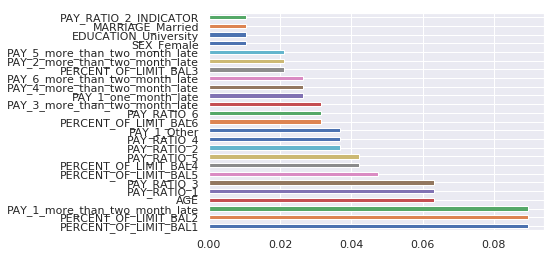

In [7]:
importances = pd.Series(loaded_model.feature_importances_, index=test_data[predictors].columns)
importances.nlargest(25).plot(kind='barh')

From this chart, we can see that the most important feature in the model are  `PAY_1_more_than_two_months_late`, `PERCENT_OF_LIMIT_BAL2`, and `PERCENT_OF_LIMIT_BAL1`  Then, there are some features that have a similar importance to each other, such as his or her age, and then their payment ratio history. It seems that the only feature describing the timing  of payments that is important is the most recent month's payment timing. After that, the ratio of a client's payment to his or her bill, along with the ratio of his or her oustanding balance compared to the balance limit are the more important features. Wholistically, payment patterns appear to be most important; it's all about the money!

This, of course, is useful, but one question that the modeler needs to always ask themselves is how much can he or she trust these findings? First off, do these findings make sense? Is age, according to the scores, really a high ranking important attribute about a customer? Second of all, we don't know for sure how the values of the features impact the model's thinking. For instance, could it be that the model acutally found that younger customers had a _lower_ chance of defaulting, when in the real world it could be the complete opposite? If this were the case, one would not have complete trust that this model is learning the appropriate patterns in the data; it might be performing well due to false findings.

What is important is to remember how sklearn implements feature importance; it does so by calculating the decrease in mean impurity. When training a tree, what is computed is how much each feature decreases the weighted impurity in a tree. For a forest, the impurity decrease from each feature can be averaged and the features are ranked according to this measure. However, there are some problems with this method. For one, the model can be biased in selected features with more categories. Secondly, correlated features' importance scores may be incorrect; for two or more correlated features, from the point of view from the model, any of  correlated features can be used as a predictor, with no significant 'preference' between them. However, once one of the correlated features is used, the importance of the other features are reduced, since the level of impurity that the latter correlated features can reduce has, in fact, already been reduced by that first correated feature, resulting in a lower importance score for the latter correlated features.


In order to ensure our models findings, we'll compare these scores with two other mehods of calculating feature importances: xgboost library's own `plot_importances` function, and a library named ELI5, which will conduct permutated feature importance.
In xgboost's function, one can specify one of three methods of calculating the importance score: "weight" is the number of times a feature appears in a tree, "gain" is the average gain of splits which use the feature, "cover" is the average coverage of splits which use the feature. "weight" will give the exact same importances as the scikit-learn function does, so we will demonstrate the 'gain' method, and compare results.



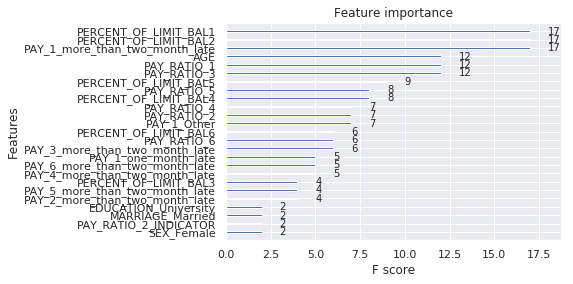

In [8]:
xgb.plot_importance(loaded_model, max_num_features=25, importance_type='weight')

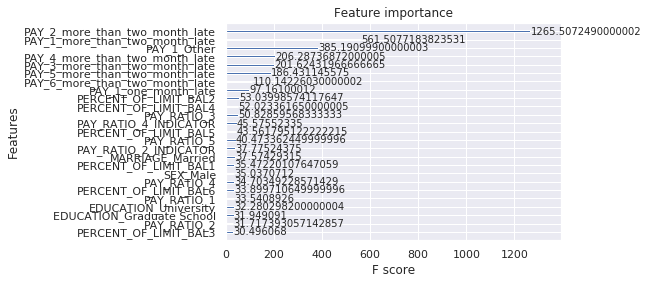

In [9]:
#xgboost method
xgb.plot_importance(loaded_model, max_num_features=25,importance_type='gain')

This chart shows that the most important features are essentially opposite of the first chart; the timing of payments for each period is wholistically the most important. Additionally, it appears that only a certain amount of features are useful: the top 8 features, from 'PAY_2_more_than_two_month_late' to 'PAY_1_one_month_late'. WHAT DOES THIS MEAN? 

With this in mind, we'll introduce another method of feature importance. This method involves is called "permutation importance", or "Mean Decrease in Accuracy". Essentially, feature importance in this method is measured by inspecting how much our unit of measure ("accuracy, R^2, etc.) decreases when a certain feature is not available. This can be done by removing a feature and retraining an estimator one at a time, and record the unit of meausure, but this is computatationally expensive.

To remedy this problem, a better solution is to remove a feature only from the test set of our data, and compute the score without using this feature. Of course, our estimator expects the same corresponding features in the training and test split, so to "remove" the feature from the test set, we shuffle the values of that feature with values of other examples within that feature. This will in essence introduce noise to that feature, and using those noisty values, we can then inspect the decrease in accuracy when using that noisy feature; the bigger the drop in accuracy, the larger the importance. 

While this can be done natively with python, we'll use the  ELI5 library, which has a handy `PermutationImportance` function that will perform the above steps. Let's see how this works.

In [10]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(loaded_model).fit(test_data[predictors], test_data[target])
eli5.show_weights(perm, feature_names = list(predictors), top=25)

Weight,Feature
0.0662 ± 0.0026,PAY_1_more_than_two_month_late
0.0146 ± 0.0046,PAY_2_more_than_two_month_late
0.0068 ± 0.0027,PAY_3_more_than_two_month_late
0.0066 ± 0.0020,PERCENT_OF_LIMIT_BAL2
0.0036 ± 0.0014,PAY_4_more_than_two_month_late
0.0027 ± 0.0019,PAY_6_more_than_two_month_late
0.0013 ± 0.0016,PAY_5_more_than_two_month_late
0 ± 0.0000,EDUCATION_Other
0 ± 0.0000,MARRIAGE_Non-married
0 ± 0.0000,PERCENT_OF_LIMIT_1_INDICATOR


The output is intuitive enough; our important variables seem to be the payment timimg, similar to the results xgboost 'gain' method of calculating feature importance, with some contribution from a client's two most recent ratios of outstanding balance to his or her limit balance.   In fact, it seems that the only variables that add any benefit are from `PAY_1_more_than_two_month_late` to `SEX_Female`; all other features add no signal to our model, as shown by the value of 0 for weight for all features below `AGE`.  


### So what do we have?

In all, we looked at three ways of interpreting our xgboost model: scikit-learn's `feature_importance_` funciton, xgboost's `plot_importance` function, and ELI5 `PermutationImportance` function, and compared to the results of our baseline RFE function results. Each shows a different combination of important features, with some methods, like Permutation Importance, showing only a handful of features actually matter. There is no way of knowing which method works best for us in our case, so we'll experiment with all of the methods and see if any can boost our scores with all of the features being used.   

## RFE feature elimination

Let's make a helper function to run the entire process and print out the results.

In [11]:
def rfe_selector(model, n_select, Train_data, test_data):
    from sklearn.feature_selection import RFE
    target = 'Y'

    selector = RFE(estimator=model, n_features_to_select=n_select, step=1)

    selector.fit(Train_data[predictors], Train_data[target])

    rankings = selector.ranking_
    
    predictors_rfe = []
    for feature, rank in zip(Train_data[predictors].columns, rankings):
        if rank == 1:
            predictors_rfe.append(feature)
        
    else:
        pass
    
    model.fit(Train_data[predictors_rfe], Train_data[target])

    y_pred_rfe = loaded_model.predict(test_data[predictors_rfe])

    print(f"Test Accuracy: {metrics.accuracy_score(test_data[target], y_pred_rfe)}")
    print(f"Test AUC: {metrics.roc_auc_score(test_data[target], y_pred_rfe)}")
    print(f"Test F1: {metrics.f1_score(test_data[target], y_pred_rfe)}")
    print(f"Features used: {predictors_rfe}")
    
    

In [12]:
#get the results for best 20, 15, 10 features
for n in [20, 15, 10]:
    print(f"Results with {n} best features:")
    rfe_selector(model=loaded_model, n_select=n, Train_data=Train_data, test_data=test_data)
    print()

Results with 20 best features:
Test Accuracy: 0.7821666666666667
Test AUC: 0.7095566088974473
Test F1: 0.5347098611605554
Features used: ['AGE', 'PERCENT_OF_LIMIT_BAL1', 'PERCENT_OF_LIMIT_BAL2', 'PERCENT_OF_LIMIT_BAL3', 'PERCENT_OF_LIMIT_BAL4', 'PERCENT_OF_LIMIT_BAL5', 'PERCENT_OF_LIMIT_BAL6', 'PAY_RATIO_1', 'PAY_RATIO_2', 'PAY_RATIO_3', 'PAY_RATIO_4', 'PAY_RATIO_5', 'PAY_RATIO_6', 'PAY_1_Other', 'PAY_1_more_than_two_month_late', 'PAY_1_one_month_late', 'PAY_2_more_than_two_month_late', 'PAY_3_more_than_two_month_late', 'PAY_5_more_than_two_month_late', 'PAY_6_more_than_two_month_late']

Results with 15 best features:
Test Accuracy: 0.774
Test AUC: 0.7054806695304401
Test F1: 0.5268667131891137
Features used: ['AGE', 'PERCENT_OF_LIMIT_BAL1', 'PERCENT_OF_LIMIT_BAL2', 'PERCENT_OF_LIMIT_BAL4', 'PERCENT_OF_LIMIT_BAL5', 'PERCENT_OF_LIMIT_BAL6', 'PAY_RATIO_1', 'PAY_RATIO_3', 'PAY_RATIO_4', 'PAY_RATIO_5', 'PAY_1_Other', 'PAY_1_more_than_two_month_late', 'PAY_1_one_month_late', 'PAY_3_more_tha

As we can see, the results do get worse with each iteration, which may not bode well for other selection methods. Anyways, let's try it now with scikit_learn's `feature_importance_` function.

In [13]:
results = pd.DataFrame(np.zeros(shape = (len(range(1, 25, 3)),4)), columns = ['accuracy', 'auc', 'f1', 'predictors_used'])
results




,accuracy,auc,f1,predictors_used
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0


In [15]:
#make a dataframe of all features used and their corresponding metrics

#reminder: importances = pd.Series(loaded_model.feature_importances_, index=Train_data[predictors].columns)

results = pd.DataFrame(np.zeros(shape = (len(range(1, 25)),4)), columns = ['accuracy', 'auc', 'f1', 'predictors_used'])

for n in range(1, 25):
    predictors_skl = list(importances.nlargest(n).index)
    loaded_model.fit(Train_data[predictors_skl], Train_data[target])

    y_pred_skl = loaded_model.predict(test_data[predictors_skl])

    accuracy = metrics.accuracy_score(test_data[target], y_pred_skl)
    results.loc[n, 'accuracy'] = accuracy
    
    auc = metrics.roc_auc_score(test_data[target], y_pred_skl)
    results.loc[n, 'auc'] = auc
    
    f1 = metrics.f1_score(test_data[target], y_pred_skl)
    results.loc[n, 'f1'] = f1
    
    results.loc[n, 'predictors_used'] = str(predictors_skl[:])
    



In [16]:
results

,accuracy,auc,f1,predictors_used
0,0.000000,0.000000,0.000000,0
1,0.543000,0.565101,0.362326,['PERCENT_OF_LIMIT_BAL1']
2,0.556833,0.575883,0.371543,"['PERCENT_OF_LIMIT_BAL1', 'PERCENT_OF_LIMIT_BA..."
3,0.789500,0.659628,0.468658,"['PERCENT_OF_LIMIT_BAL1', 'PERCENT_OF_LIMIT_BA..."
4,0.786500,0.660813,0.470004,"['PERCENT_OF_LIMIT_BAL1', 'PERCENT_OF_LIMIT_BA..."
5,0.769833,0.671587,0.482578,"['PERCENT_OF_LIMIT_BAL1', 'PERCENT_OF_LIMIT_BA..."
6,0.775833,0.677097,0.491493,"['PERCENT_OF_LIMIT_BAL1', 'PERCENT_OF_LIMIT_BA..."
7,0.769500,0.686572,0.502339,"['PERCENT_OF_LIMIT_BAL1', 'PERCENT_OF_LIMIT_BA..."
8,0.763500,0.678248,0.490119,"['PERCENT_OF_LIMIT_BAL1', 'PERCENT_OF_LIMIT_BA..."
9,0.763667,0.683420,0.496806,"['PERCENT_OF_LIMIT_BAL1', 'PERCENT_OF_LIMIT_BA..."


In [17]:
predictors_bestskl = (results.iloc[22]['predictors_used'])

print(predictors_bestskl)

['PERCENT_OF_LIMIT_BAL1', 'PERCENT_OF_LIMIT_BAL2', 'PAY_1_more_than_two_month_late', 'AGE', 'PAY_RATIO_1', 'PAY_RATIO_3', 'PERCENT_OF_LIMIT_BAL5', 'PERCENT_OF_LIMIT_BAL4', 'PAY_RATIO_5', 'PAY_RATIO_2', 'PAY_RATIO_4', 'PAY_1_Other', 'PERCENT_OF_LIMIT_BAL6', 'PAY_RATIO_6', 'PAY_3_more_than_two_month_late', 'PAY_1_one_month_late', 'PAY_4_more_than_two_month_late', 'PAY_6_more_than_two_month_late', 'PERCENT_OF_LIMIT_BAL3', 'PAY_2_more_than_two_month_late', 'PAY_5_more_than_two_month_late', 'SEX_Female']


The best comibination of AUC and F1 resulted from using the features in `predictors_bestskl`. However, these results aren't that much different from previous results, so we'll continue with trying out feature combinations using xgboost's method.

In [25]:
predictors_xgb = ['PAY_2_more_than_two_month_late', 'PAY_1_more_than_two_month_late', 'PAY_1_Other',
                 'PAY_4_more_than_two_month_late', 'PAY_3_more_than_two_month_late', 'PAY_5_more_than_two_month_late',
                 'PAY_6_more_than_two_month_late', 'PAY_1_one_month_late']

def score_model(model, predictors, target, Train_data, test_data):
    model.fit(Train_data[predictors], Train_data[target])

    y_pred = loaded_model.predict(test_data[predictors])

    print(f"Test Accuracy: {metrics.accuracy_score(test_data[target], y_pred)}")
    print(f"Test AUC: {metrics.roc_auc_score(test_data[target], y_pred)}")
    print(f"Test F1: {metrics.f1_score(test_data[target], y_pred)}")

score_model(loaded_model, predictors_xgb, target=target, Train_data=Train_data, test_data=test_data)

Test Accuracy: 0.7805
Test AUC: 0.7062435194785958
Test F1: 0.5301462718515876


Again, the results are not changing by much. Lastly, let's try ELI5's best features...

In [26]:
predictors_eli5 = ['PAY_1_more_than_two_month_late', 'PAY_2_more_than_two_month_late', 'PAY_3_more_than_two_month_late',
                  'PAY_4_more_than_two_month_late', 'PAY_5_more_than_two_month_late', 'PAY_6_more_than_two_month_late',
                  'PERCENT_OF_LIMIT_BAL2']

score_model(loaded_model, predictors_eli5, target=target, Train_data=Train_data, test_data=test_data)

Test Accuracy: 0.8091666666666667
Test AUC: 0.7042388781908855
Test F1: 0.5396059509449136


__These seem to be the best combination of predictors: it produced the highest accuracy and the highest f1 score of any set of features__. 

# Checkpoint: need to describe these results and need to check xgboost features and eli5 features

# Partial Dependence Plots

Now that we have a final set of features to use with our xgboost model, we're going to look deeper into how the values of these features affect the output. The tool we will be using are Partial Dependence Plots, or PDP. In essence, a partial dependence plot shows the marginal effect one or two features have on the predicted outcome of a machine learning model, assuming the features are independent, or uncorrelated with the other features in our predictor set. MORE EXPLANATION 

Source: https://christophm.github.io/interpretable-ml-book/pdp.html

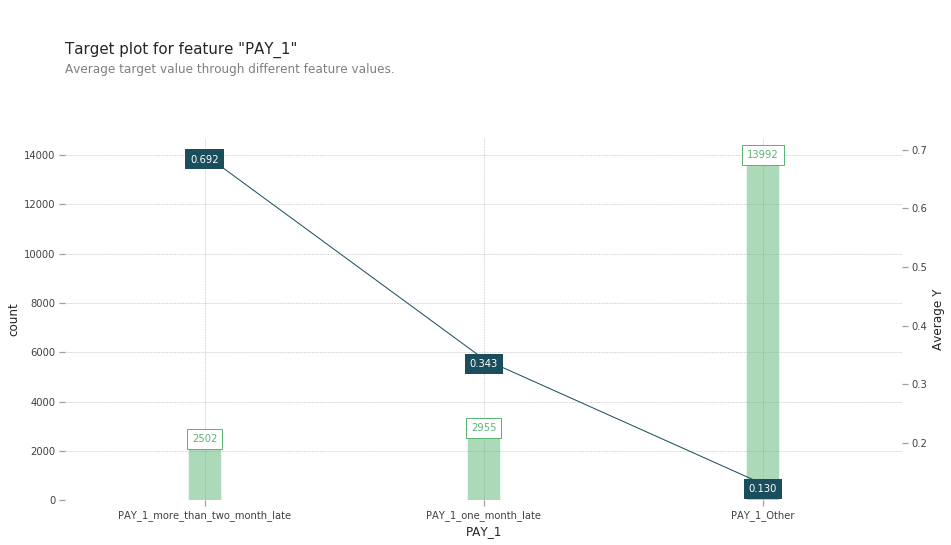

In [45]:
from pdpbox import pdp, get_dataset, info_plots

fig, axes, summary_df = info_plots.target_plot(
    df=Train_data, feature=['PAY_1_more_than_two_month_late', 'PAY_1_one_month_late','PAY_1_Other'], feature_name='PAY_1',
target = target
)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd358f77908>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd358f8c400>})

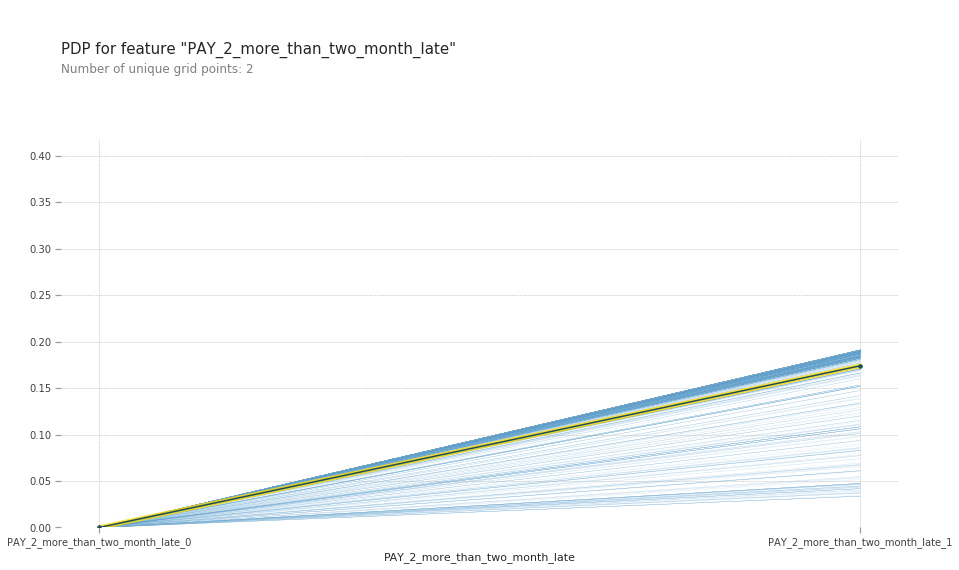

In [33]:
from pdpbox import pdp, get_dataset, info_plots

p = pdp.pdp_isolate(loaded_model, Train_data[predictors_eli5],predictors_eli5, 'PAY_2_more_than_two_month_late')

pdp.pdp_plot(p, 'PAY_2_more_than_two_month_late',plot_lines=True, frac_to_plot= )


We can check local examples to see how the values of these features affect the model's predictions. We use the INSERT HERE.

In [72]:
print(f"the model predicted:")
eli5.show_prediction(rf, doc= X_val.values[2019], 
                     show_feature_values = True, 
                     feature_names = list(X_train.columns),
                    )

the model predicted:


From the UCI dataset website:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables: 
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- X2: Gender (1 = male; 2 = female). 
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- X4: Marital status (1 = married; 2 = single; 3 = others). 
- X5: Age (year). 
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005;
- X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
- X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005. 